# KNN Results Comparison

In [21]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
smith_results = pd.read_csv("./results/representation_learning_transcriptomics_results.csv")
tcga_classification_tasks = pd.read_csv("./data_utilities/tcga_classification_tasks.csv")
tcga_results_knn = pd.read_csv("./results/tcga_results.csv")

In [3]:
binary = smith_results['label_type'] == 'binary'
knn = smith_results['supervised_model'] == 'k nearest neighbor'
no_embedding = smith_results['unsupervised_model'] == 'no embedding'
gene_set = smith_results['gene_set'] == 'all'
norm = smith_results['normalization'] == 'clr'
tcga = ["GSE" not in e for e in smith_results['task']]

In [4]:
tcga_results_smith = smith_results[binary & knn & no_embedding & gene_set & norm & tcga]

In [5]:
def create_task(filename):
    cancer, task = filename.split('_')[3:5]
    class_ = task.split('.')[0]
    return (" ".join([cancer, class_]))

In [6]:
tcga_results_knn['task'] = [create_task(f) for f in tcga_classification_tasks['filename']]

In [7]:
tcga_results_smith.head()

,unsupervised_model,supervised_model,gene_set,normalization,task,group,label_type,num_genes,num_features,num_samples,num_classes,score,score_units
601,no embedding,k nearest neighbor,all,clr,STAD stage,train,binary,57992,57992,416,2,0.589089,AUC
602,no embedding,k nearest neighbor,all,clr,KIRC grade,train,binary,57992,57992,544,2,0.504933,AUC
603,no embedding,k nearest neighbor,all,clr,LUSC stage,validate,binary,57992,57992,504,2,0.571299,AUC
604,no embedding,k nearest neighbor,all,clr,PAAD grade,train,binary,57992,57992,179,2,0.595513,AUC
605,no embedding,k nearest neighbor,all,clr,BRCA stage,test,binary,57992,57992,1134,2,0.595413,AUC


In [8]:
tcga_results_knn.sort_values(by='task', inplace=True)
tcga_results_smith.sort_values(by='task', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
# check they are aligned correctly
assert(all( [a == b for a,b in zip(tcga_results_smith['task'], tcga_results_knn['task'])] ))

In [10]:
sns_data = pd.DataFrame()

In [11]:
sns_data['Task'] = tcga_results_knn['task']
sns_data['OurResults'] = tcga_results_knn['results'].values
sns_data['SmithResults'] = tcga_results_smith['score'].values
sns_data

,Task,OurResults,SmithResults
8,BRCA stage,0.557111,0.595413
1,CESC grade,0.640002,0.607986
3,COAD stage,0.596567,0.573999
2,HNSC grade,0.581275,0.563065
11,KIRC grade,0.506088,0.504933
15,KIRC stage,0.697010,0.689159
16,LGG grade,0.647965,0.678684
10,LIHC grade,0.642339,0.618890
12,LIHC stage,0.584741,0.548880
0,LUAD stage,0.594248,0.587241


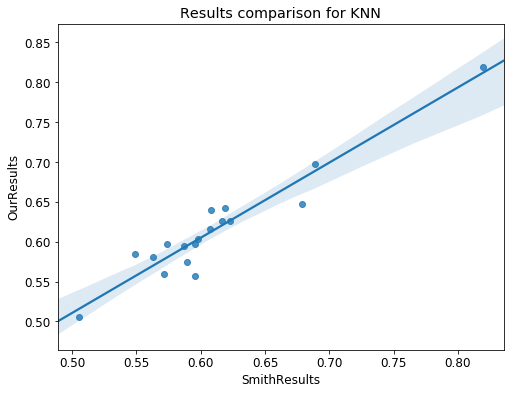

In [12]:
plt.rcParams['figure.figsize'] = 8.0, 6.0
plt.rcParams['font.size'] = 12.0
sns.regplot(data=sns_data, x="SmithResults", y="OurResults")
plt.title('Results comparison for KNN');

In [13]:
# test for bias
from scipy.stats import ttest_rel

In [14]:
ttest_rel(b=sns_data['SmithResults'], a=sns_data['OurResults'])

Ttest_relResult(statistic=0.9662183504510224, pvalue=0.34748034892897217)

In [15]:
# no bias present

In [31]:
sns_data['Differences'] = sns_data['OurResults'] - sns_data['SmithResults']
sns_data.sort_values(by='Differences', inplace=True)
n_obs = len(sns_data)

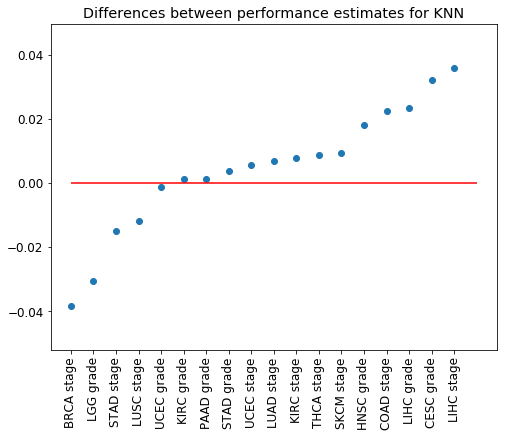

In [32]:
plt.scatter(x=sns_data['Task'], y=sns_data['Differences'])
plt.hlines(y=0, xmin=0, xmax=n_obs, colors='r')
plt.xticks(rotation=90);
plt.title("Differences between performance estimates for KNN");

Now let's aggregate the data from the parallesised runs

In [22]:
filenames = os.listdir("./results/knn")
results = [pd.read_csv(f"./results/knn/{f}") for f in filenames]

In [23]:
mean_performance = [r['auc'].mean() for r in results]
tasks = [" ".join(f.split('_')[3:5]) for f in filenames]

In [24]:
aggregated_results = pd.DataFrame()
aggregated_results['results'] = mean_performance
aggregated_results['task'] = tasks

In [25]:
aggregated_results.sort_values(by='task', inplace=True)
sns_data.sort_values(by='Task', inplace=True)

In [26]:
# check they are aligned correctly
assert(all( [a == b for a,b in zip(aggregated_results['task'], sns_data['Task'])] ))

In [27]:
sns_data['OurAggregatedResults'] = aggregated_results['results'].values # need `.values` to stop pandas re-sorting
sns_data

,Task,OurResults,SmithResults,Differences,OurAggregatedResults
8,BRCA stage,0.557111,0.595413,-0.038302,0.557111
1,CESC grade,0.640002,0.607986,0.032016,0.640002
3,COAD stage,0.596567,0.573999,0.022568,0.596567
2,HNSC grade,0.581275,0.563065,0.018210,0.581275
11,KIRC grade,0.506088,0.504933,0.001155,0.506088
15,KIRC stage,0.697010,0.689159,0.007851,0.697010
16,LGG grade,0.647965,0.678684,-0.030719,0.647965
10,LIHC grade,0.642339,0.618890,0.023449,0.642339
12,LIHC stage,0.584741,0.548880,0.035860,0.584741
0,LUAD stage,0.594248,0.587241,0.007007,0.594248


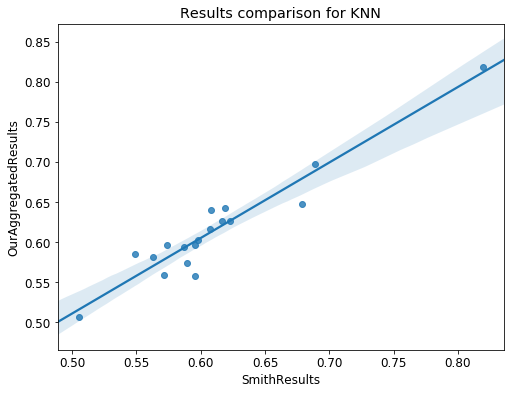

In [28]:
sns.regplot(data=sns_data, x="SmithResults", y="OurAggregatedResults")
plt.title('Results comparison for KNN');

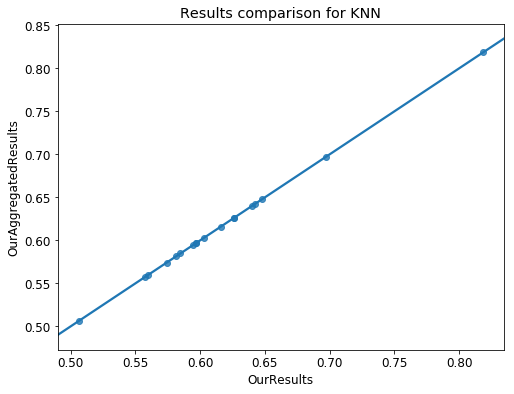

In [29]:
# us vs us
sns.regplot(data=sns_data, x="OurResults", y="OurAggregatedResults")
plt.title('Results comparison for KNN');